<a href="https://colab.research.google.com/github/andcut/DeepLexicalHypothesis/blob/main/DeepLexicalHypothesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The lexical hypothesis claims that personality structure is embedded in natural language. Traditionally this structure has been interrogated by representing personality adjectives as vectors, each dimension being whether participant x agrees the word describes her. Such experiments show roughly five latent factors of personality. Deep Learning models are a more powerful way to vectorize words. They are trained on most books ever written as well as much of the internet, and dominate natural language processing benchmarks.

This notebook reproduces experiments from the Lexical Hypothesis chapter of my dissertation [Language Modeling for Personality Prediction](https://open.bu.edu/handle/2144/41942). After loading the modules, pretrained language model, and adjective lists this notebook:

1.   Performs factor analysis on one of several sets of words. Words are plotted on the resulting factors. With default settings, two factors emerge: socialization and self-actualization.
2.   Each factor can be thought of as a vector pointing in 1024 dimensional space (the size of the RoBERTa embedding). So one can qualitatively compare different experiments. Are the same factors recovered? Two sets of words are created, basic and advanced. The resulting factors are correlated and eigenvalues compared.
3.   Phrases can be embedded as well. 20 IPIP questions are projected onto factors obtained above.
4.   A multi-lingual model is uploaded. Words in English and Spanish recover two shared factors. Please expand this to other languages!

In [ ]:
#import modules and install fairseq (for the language models)
#installing fairseq may take a couple minutes
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
!pip install fairseq

In [ ]:
#load roberta to the gpu
#might get a runtime error that no GPUs are available
#if so try again, that usually works
if 'roberta' not in locals(): 
    roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')
    roberta.eval()  # disable dropout (or leave in train mode to finetune)
    roberta.cuda()

In [3]:
#add mask_embedding_function to roberta
#this takes a sentence that has a single <mask> token and returns the RoBERTa embedding of <mask>
#works better than using the <cls> token or actual adjective's token
#for more on those results see Language Modeling for Personality Prediction Chapter: Lexical Hypothesis (dissertation)
import fairseq
from fairseq import utils
from fairseq.data import encoders

def extract_mask_embedding(self, masked_input: str):
    masked_token = "<mask>"
    assert (
        masked_token in masked_input and masked_input.count(masked_token) == 1
    ), "Please add one {0} token for the input, eg: 'He is a {0} guy'".format(
        masked_token
    )

    text_spans = masked_input.split(masked_token)
    text_spans_bpe = (
        (" {0} ".format(masked_token))
        .join([self.bpe.encode(text_span.rstrip()) for text_span in text_spans])
        .strip()
    )
    tokens = self.task.source_dictionary.encode_line(
        "<s> " + text_spans_bpe + " </s>",
        append_eos=False,
        add_if_not_exist=False,
    )

    masked_index = (tokens == self.task.mask_idx).nonzero()
    if tokens.dim() == 1:
        tokens = tokens.unsqueeze(0)

    with utils.model_eval(self.model):
        features, extra = self.model(
            tokens.long().to(device=self.device),
            features_only=True,
            return_all_hiddens=False,
        )
    logits = features[0, masked_index, :].squeeze()
    prob = logits.softmax(dim=0)
    #can return prob for an embedding vector the size of the dictionary.
    #need to get features before that layer tho.
    return prob.cpu().detach().numpy()

fairseq.models.roberta.hub_interface.RobertaHubInterface.extract_mask_embedding = extract_mask_embedding

In [ ]:
#load adjective lists from Andrew's Github
!git clone https://github.com/andcut/DeepLexicalHypothesis.git

In [5]:
#load personality adjectives as a numpy list
#for convenience, all the filenames are in this array.
f_names = ["2k_words","7esl_personality_adjectives","Thurstone_big5_words","webster_personality_adjectives"]
adjectives = pd.read_csv("DeepLexicalHypothesis/" +f_names[-1] + ".csv", header = None, encoding = "latin").values
adjectives = np.squeeze(adjectives)
adjectives = np.unique(adjectives) #squeeze and unique to make sure there are no duplicates or extra dimensions.

In [ ]:
#Now construct a sentence that implies <mask> is a synonym for a personality adjective
#some options are:
# t_sentences = ["<mask> is another word for someone who is " + word + "." for word in t_words]
# t_sentences = ["I am a <mask> and " + word + " person." for word in t_words]
adj_sentences = ["My personality can be described as <mask> and " + word + "." for word in adjectives]

# the embedding sentence is the biggest modeling choice. Not all produce nice results
# I tried to get at general personality. Might be able to phrase the question to bias it to certain situations

#vectorize each sentence using roberta. Will take a minute
#each word will now be represented as a vector of length 1024
#This includes lots of information: grammar, register (eg. kingly vs royal), and hopefully much personality
adj_vec = [roberta.extract_mask_embedding(sentence) for sentence in adj_sentences]

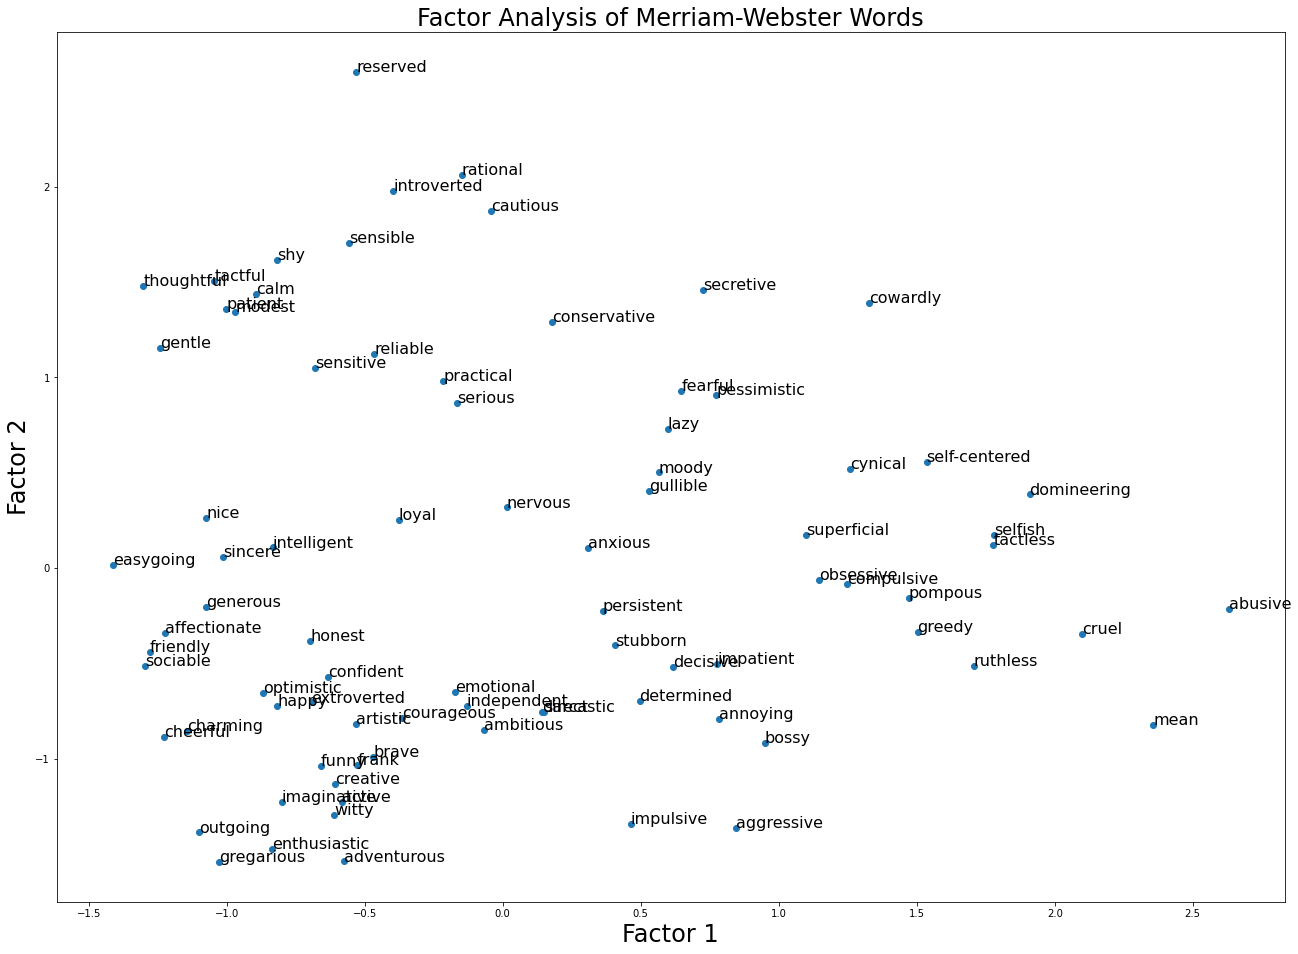

In [7]:
#Factor Analysis (or you can do pca, results are almost identical)
#In my experience n_components doesn't matter, but feel free to check out later factors
n_components = 10
reducer = FactorAnalysis(n_components = n_components)
adj_reduced = reducer.fit_transform(np.array(adj_vec))

#plot the axis two at a time
for i in range(1): #set range(int(n_components/2)) to see all factors
    x = adj_reduced[:,2*i]
    y = adj_reduced[:,2*i+1]
    plt.figure(figsize=(22,16)) #note this is not square. Easier to read, not to scale
    plt.scatter(x,y)
    plt.xlabel("Factor "+str(2*i+1), fontsize = 24)
    plt.ylabel("Factor "+str(2*i+2), fontsize = 24)
    plt.title("Factor Analysis of Merriam-Webster Words", fontsize = 24)
    for j,word in enumerate(adjectives):
        plt.text(x[j], y[j], word, fontsize=16)
    plt.show()
#make fontsize smaller and figure size bigger if plotting many words.

In [8]:
#A qualitative assessment can be made of the basic experiment based on word plot
#This next section takes a qualitative look
#basic words are those in the ESL guide and webster's core personality words
basic_fnames = ["7esl_personality_adjectives","webster_personality_adjectives"]
basic_words = []
for fname in basic_fnames:
    basic_words += pd.read_csv("DeepLexicalHypothesis/" + fname + ".csv", header = None, encoding = "latin").values.squeeze().tolist()

basic_words = np.unique(basic_words).tolist()

#advanced words are those in ideonomy's adjective list or an 800 word guide for writers describing characters
#basic words are removed from this list so there is no overlap
#could probabably come up with better word lists but as you see the factors aren't that effected    
advanced_words = pd.read_csv("DeepLexicalHypothesis/2k_words.csv", header = None, encoding = "latin").values.squeeze()
advanced_words = np.unique(advanced_words)
advanced_words = [word for word in advanced_words if word not in basic_words]

In [9]:
#vectorize basic and advanced words. <1k words. Will take a few min
#google colab is free, but the GPU's aren't great
b_sentences = ["My personality can be described as <mask> and " + word + "." for word in basic_words]
b_vec = [roberta.extract_mask_embedding(sentence) for sentence in b_sentences]

a_sentences = ["My personality can be described as <mask> and " + word + "." for word in advanced_words]
a_vec = [roberta.extract_mask_embedding(sentence) for sentence in a_sentences]

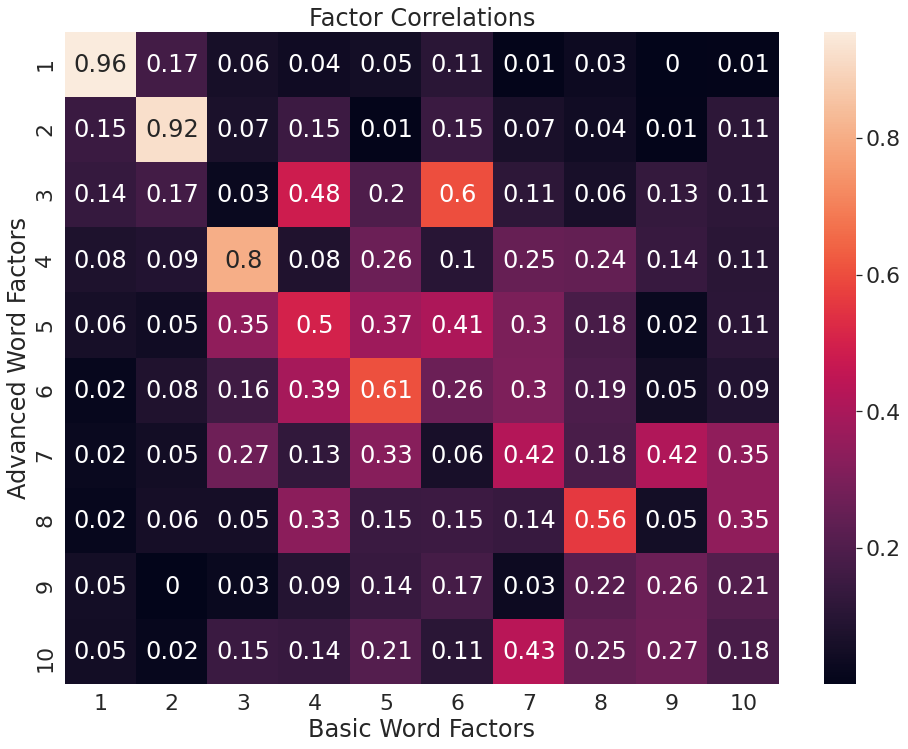

In [10]:
n_components = 10
b_reducer = PCA(n_components = n_components)
b_reducer.fit(b_vec)

a_reducer = PCA(n_components = n_components)
a_reducer.fit(a_vec)

#find correlation of factor structure  
a = a_reducer.components_
b = b_reducer.components_
c = np.corrcoef(b,a)
d = c[n_components:n_components + 10,:10]

# plot correlation
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(abs(d), ax = ax,xticklabels = range(1,11), yticklabels = range(1,11), annot = abs(np.round(d,2)))
ax.set_title("Factor Correlations")
ax.set_xlabel("Basic Word Factors")
ax.set_ylabel("Advanced Word Factors")
plt.show()

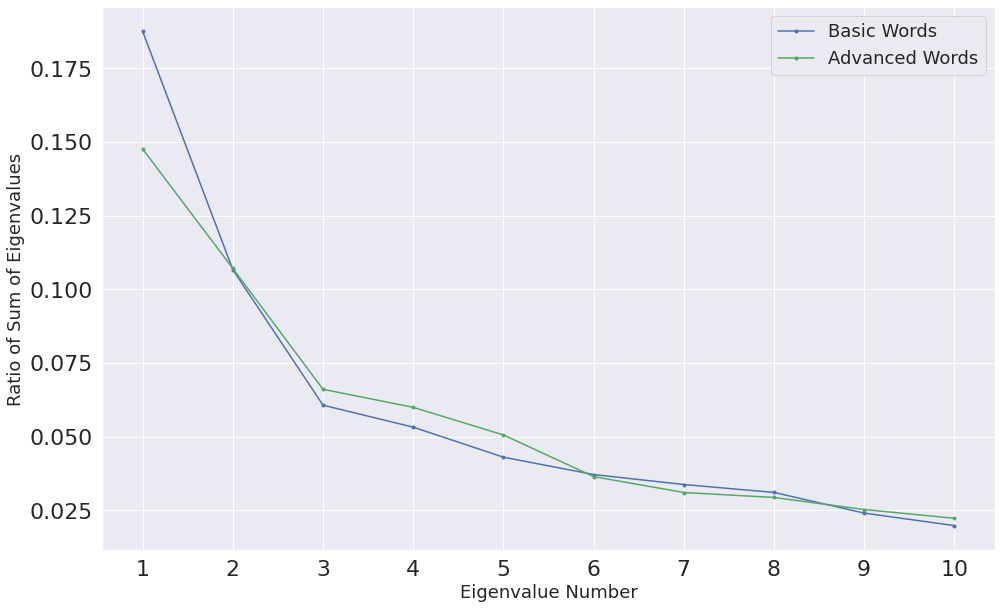

<Figure size 432x288 with 0 Axes>

In [11]:
#plot eigenvalues
plt.figure(figsize = (16,10))
plt.plot(range(1,11),b_reducer.explained_variance_ratio_[:10], marker = ".", color = 'b')
plt.plot(range(1,11),a_reducer.explained_variance_ratio_[:10], marker = ".", color = 'g')
plt.legend(["Basic Words","Advanced Words"], fontsize = 18)
# plt.title("Eigenvalues of RoBERTa Embedding", fontsize = 22)
plt.xlabel("Eigenvalue Number",fontsize = 18)
plt.ylabel("Ratio of Sum of Eigenvalues", fontsize = 18)
plt.xticks(ticks = range(1,11))
plt.show()
plt.clf()
#after this plot all others have a grey background. Too dumb to know why.

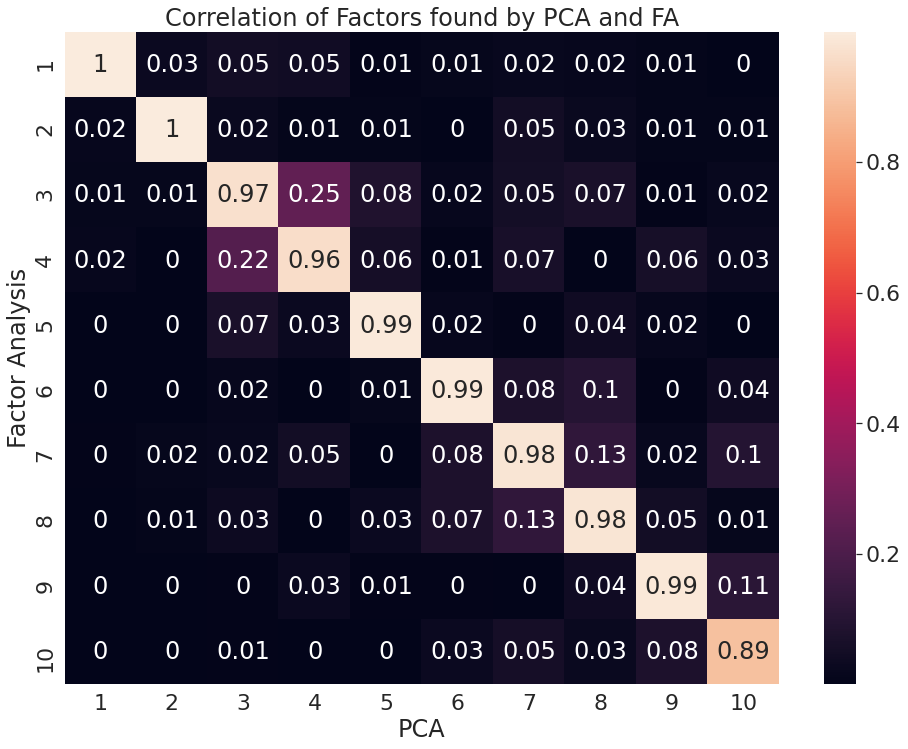

In [12]:
#comparison of PCA and FA
n_components = 10
pca_reducer = PCA(n_components = n_components)
pca_reducer.fit(b_vec)

fa_reducer = FactorAnalysis(n_components = n_components)
fa_reducer.fit(b_vec)


#find correlation of factor structure  
pca_factors = pca_reducer.components_
fa_factors = fa_reducer.components_
factor_corrs = np.corrcoef(fa_factors,pca_factors)
factor_corrs_corner = factor_corrs[n_components:n_components*2,:n_components]

# plot correlation
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(abs(factor_corrs_corner), ax = ax,xticklabels = range(1,11),yticklabels = range(1,11), annot = abs(np.round(factor_corrs_corner,2)))
ax.set_title("Correlation of Factors found by PCA and FA")
ax.set_xlabel("PCA")
ax.set_ylabel("Factor Analysis")
plt.show()

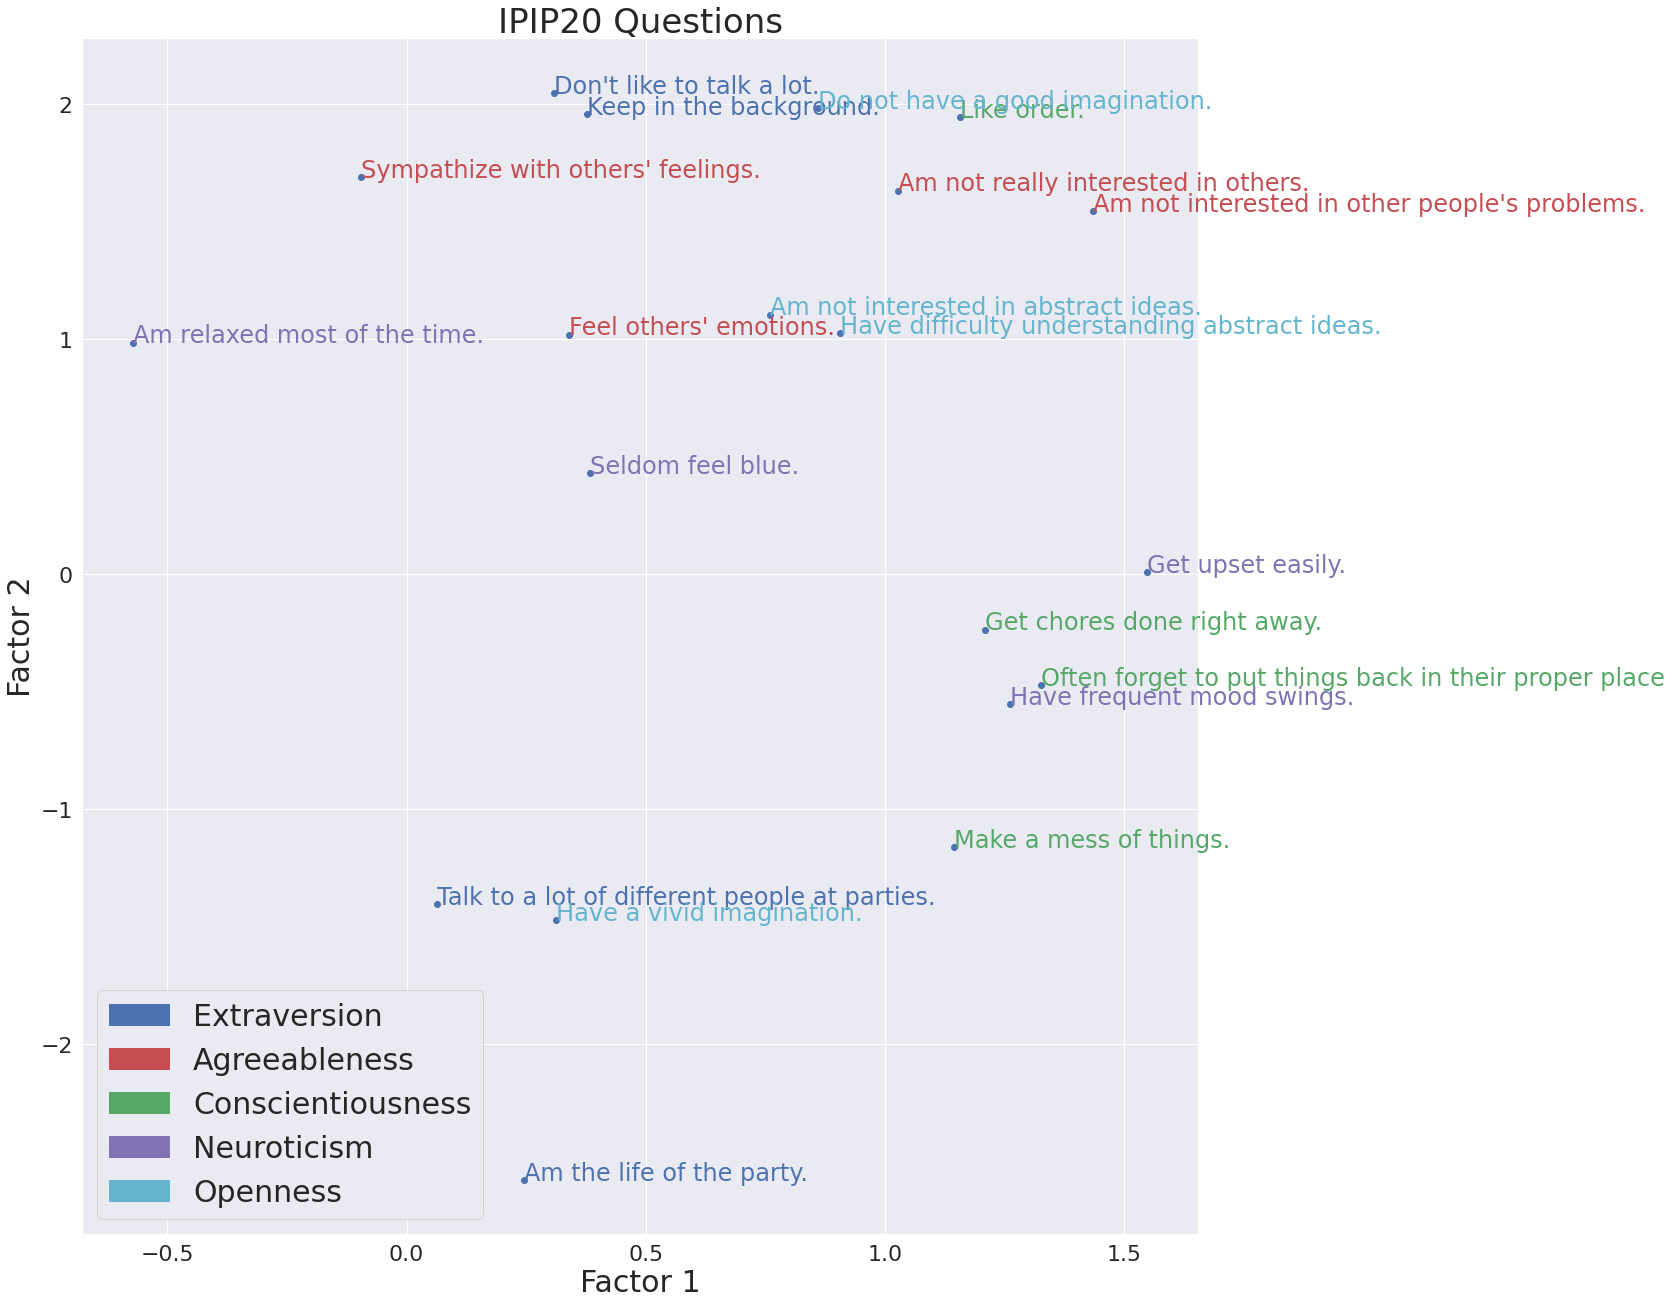

In [13]:
#Embed and project common big5 inventory questions from https://ipip.ori.org/
IPIP = pd.read_csv("DeepLexicalHypothesis/ipip20.tsv",delimiter = "\t")
IPIP = pd.DataFrame(IPIP)
IPIP_sentences = IPIP["sentence 3"]
IPIP_vec = [roberta.extract_mask_embedding(sentence) for sentence in IPIP_sentences]
IPIP_reduced = reducer.transform(IPIP_vec)

#This uses factors from the first experiment. 
#Can also use eg a_reducer

import matplotlib.patches as mpatches
big5 = ["Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]
colors = ['b','r','g','m','c']

x = IPIP_reduced[:,0]
y = IPIP_reduced[:,1]
plt.figure(figsize=(20,22))
plt.scatter(x,y)
plt.xlabel("Factor 1", fontsize = 30)
plt.ylabel("Factor 2", fontsize = 30)
plt.title("IPIP20 Questions", fontsize = 34)
for j,word in enumerate(IPIP["Mini-IPIP Question"]):
    plt.text(x[j], y[j], word, fontsize=24, color = colors[int(j/4)])
plt.legend(handles=[mpatches.Patch(color = colors[i], label = big5[i]) for i in range(len(colors))], fontsize = 30)
plt.show()

If everything went right, phrases will be sensibly projected onto axis found by factorizing words. This next section uses a multi-lingual language model, XLM-R to embed words in both english and spanish. The two shared factors look like socialization and self-actualization.

In [14]:
!pip install sentencepiece
if 'xlmr' not in locals(): 
    xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.large')
    xlmr.eval()  # disable dropout (or leave in train mode to finetune)
    xlmr.cuda()
    
##load words## 
#let "t" be abrev for Thurstone, who first gathered the list of words
words = pd.read_csv("DeepLexicalHypothesis/webster_english_spanish.csv", encoding='latin-1')
english_words = words['english'].values.squeeze()
spanish_words = words['spanish'].values.squeeze()

#english sentences
sentences = ["My personality can be described as <mask> and " + word + "." for word in english_words] 
sentences +=["Mi personalidad se puede describir como <mask> y " + word +"." for word in spanish_words]
adj_vec = [xlmr.extract_mask_embedding(sent) for sent in sentences]

##Dimensionality reduction##
n_components = 5
reducer = FactorAnalysis(n_components = n_components)
adj_reduced = reducer.fit_transform(np.array(adj_vec))

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master


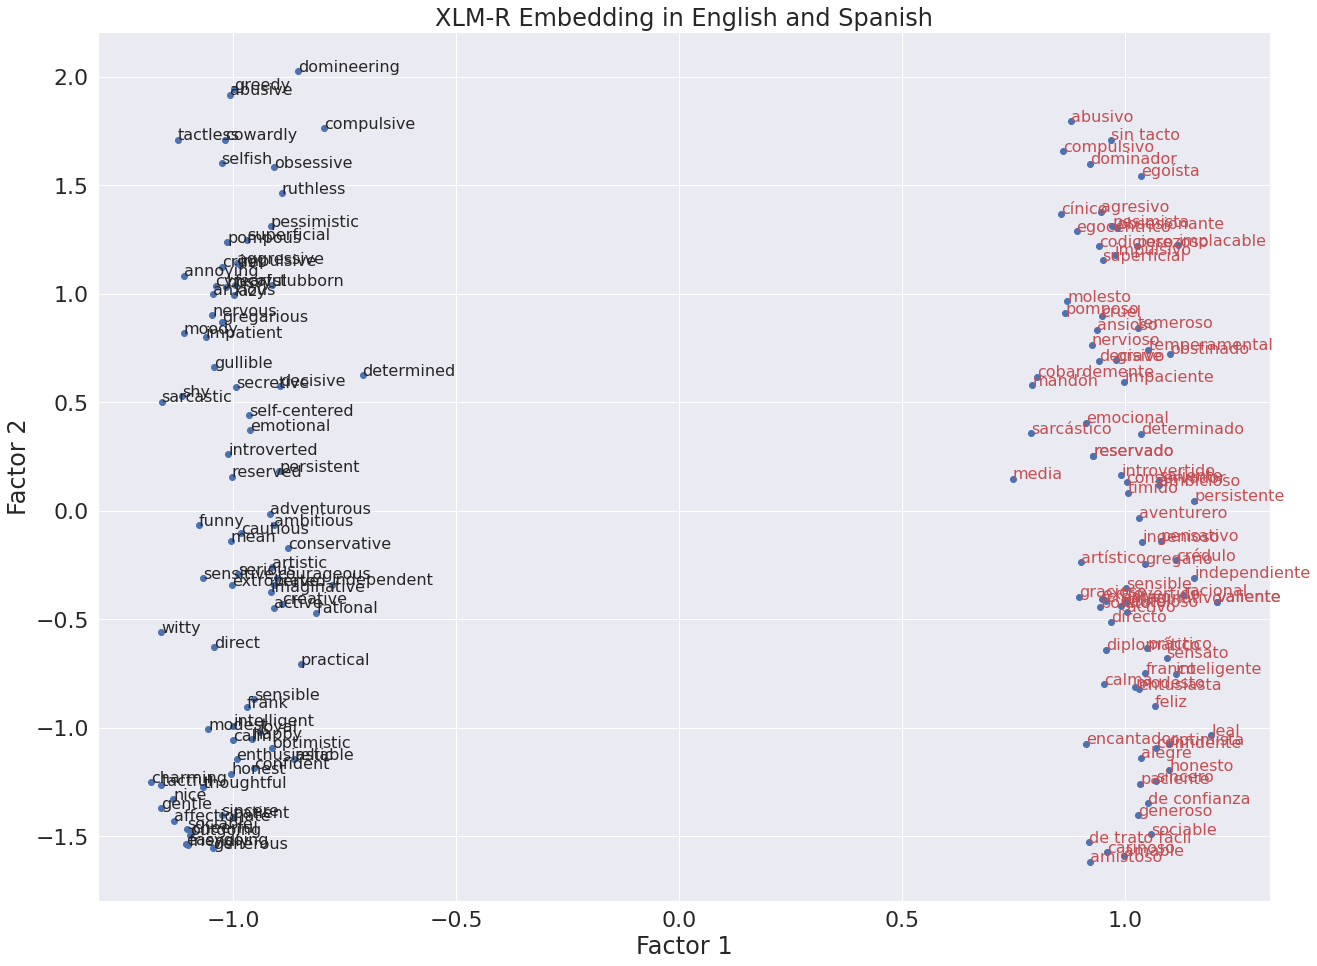

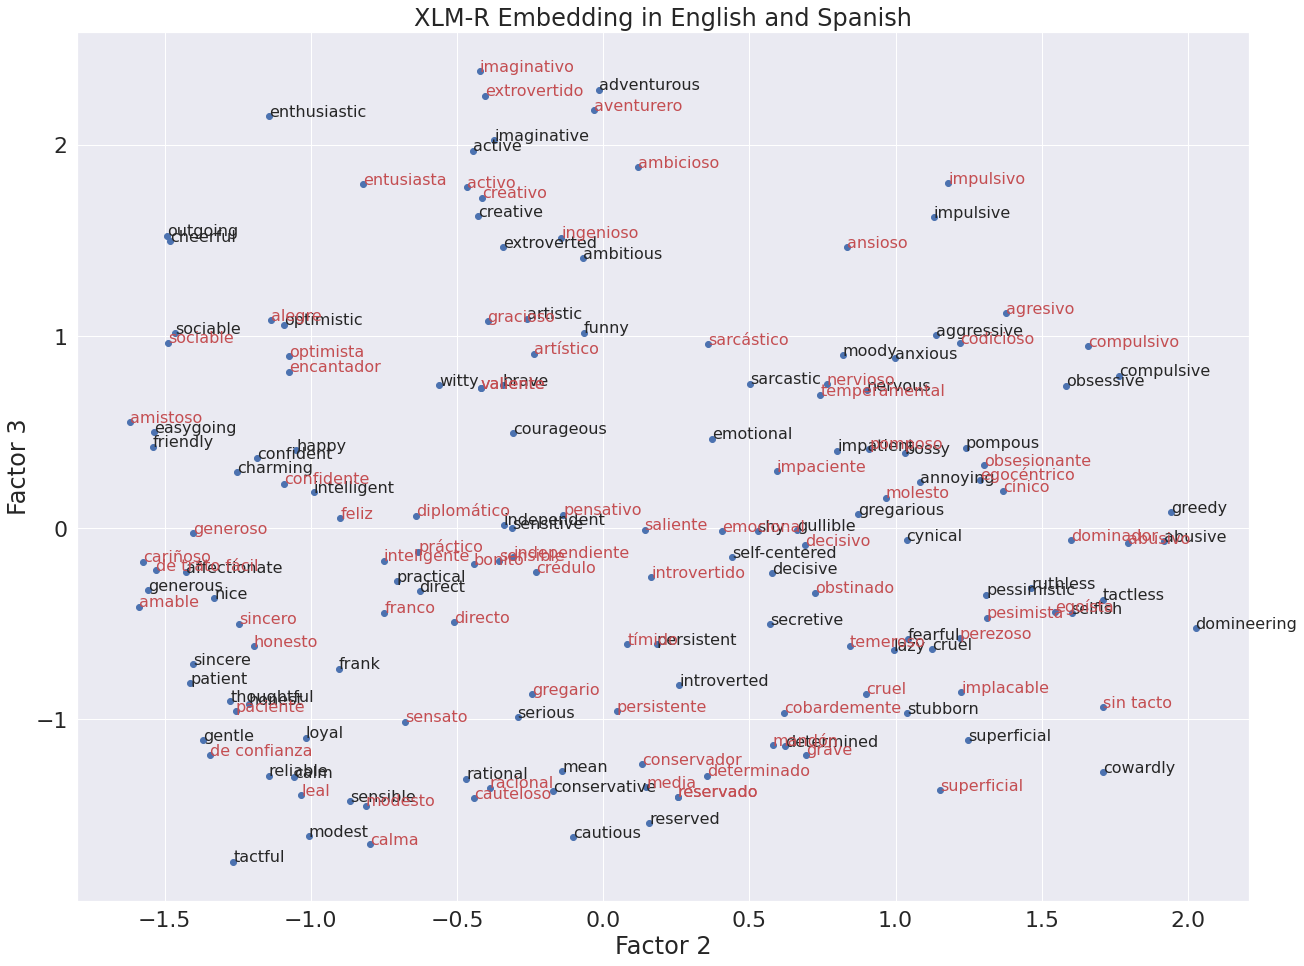

In [15]:
#plot results
#the first dimension separates the languages
#the second and third are socialization and self-actualization.
words = english_words.tolist() + spanish_words.tolist()
for i in range(2):
    x = adj_reduced[:,i]
    y = adj_reduced[:,i+1]
    plt.figure(figsize=(21,16))
    plt.scatter(x,y)
    plt.xlabel("Factor "+str(i+1), fontsize = 24)
    plt.ylabel("Factor "+str(i+2), fontsize = 24)
    plt.title("XLM-R Embedding in English and Spanish", fontsize = 24)
    for j,word in enumerate(words):
        if j<len(words)/2:
            plt.text(x[j], y[j], word, fontsize=16)
        else:
            plt.text(x[j], y[j], word, fontsize=16, color = 'r')
    plt.show()